In [1]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
BANDIT_REWARD = [1, 2, 3, 4]
NUMBER_OF_TRIALS = 20000
EPS = 0.1

In [3]:
class Bandit(ABC):
    ##==== DO NOT REMOVE ANYTHING FROM THIS CLASS ====##

    @abstractmethod
    def __init__(self, reward):
        self.reward = reward

    @abstractmethod
    def __repr__(self):
        pass

    @abstractmethod
    def pull(self):
        pass

    @abstractmethod
    def update(self):
        pass

    @abstractmethod
    def experiment(self):
        pass

    @abstractmethod
    def plot1(self): # you name it
        # Visualize the performance of each bandit
        pass

    @abstractmethod
    def report(self):
        # store the data in csv
        # print the average reward: using logging package
        # print average regret: using logging package
        pass

In [4]:
class EpsilonGreedy(Bandit):
    
    def __init__(self, reward):
        self.reward = reward
        self.reward_estimate = 0
        self.N = 0
    
    def __repr__(self):
        return f'A Bandit with {self.reward} Reward'
    
    def pull(self):
        return np.random.randn() + self.reward
    
    def update(self, x):
        self.N += 1
        self.reward_estimate = (1 - 1.0/self.N) * self.reward_estimate + 1.0/ self.N * x

    def experiment(self, bandit_rewards, t, N=NUMBER_OF_TRIALS):
        
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        
        # the number of suboptimal choices
        means = np.array(bandit_rewards)
        true_best = np.argmax(means)
        count_suboptimal = 0
                
        # empty array to later add the rewards for inference plots
        eg_reward = np.empty(N)
        eg_selected_bandit = []
        eps = 1/t

        for i in range(N):
            #generating a random number 
            p = np.random.random() 
            
            # if the random number is smaller than eps we explore a random bandit
            if p < eps:  
                j = np.random.choice(len(bandits)) 
            else:
                # if the random number is bigger than eps we explore the bandit with the highest current reward
                j = np.argmax([b.reward_estimate for b in bandits])
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()
            
            # increases N by 1 and calculates the estimate of the reward
            bandits[j].update(x) 
            
            # if j is not the actual true best bandit, the suboptimal bandit count increments by 1
            if j != true_best: 
                count_suboptimal += 1
            
            # add the selected bandit to the list of selected bandits
            eg_selected_bandit.append(j)
            
            # add the reward to the data
            eg_reward[i] = x
            
            # increase t, i.e., decrease the probability of choosing suboptimal (random) bandit
            t += 1
            eps = 1/t
        
        all_bandits = pd.DataFrame({"Bandit" : eg_selected_bandit, "Reward" : eg_reward, "Algorithm" : "Epsilon Greedy"})
        all_bandits.to_csv("./csv/EpsilonGreedy_All.csv")
        
        return eg_reward, eg_selected_bandit, eps, count_suboptimal
    
    def plot1(self, eg_reward, eg_selected_bandit, bandit_rewards, N=NUMBER_OF_TRIALS):
        
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        actual_rewards = []
        for i in eg_selected_bandit:
            actual_rewards.append(bandits[i].reward)
            
        true_best = max(bandit_rewards)
        best_reward = np.arange(N)
        
        regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(eg_reward)   # with estimated reward
        # regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(actual_rewards)   # with actual reward
        
        plt.figure(figsize=(10, 8))
        plt.plot(np.cumsum(eg_reward), label = "Cumulative Reward", color = 'g')
        plt.plot(regret, label = "Cumulative Regret", color = 'r')
        plt.title("Cummulative Reward and Regret", fontsize=20)
        plt.xlabel("Number of Trials", fontsize=14)
        plt.ylabel("Estimated Reward", fontsize=14)
        plt.legend()
        plt.show()

    def report(self, bandit_rewards, eps, count_suboptimal, N=NUMBER_OF_TRIALS):
        
        bandits = [EpsilonGreedy(reward) for reward in bandit_rewards]
        
        cumulative_average = np.cumsum(eg_reward) / (np.arange(N) + 1)
        for b in bandits:
            print(f"Estimated average reward where epsilon for {b} = {eps} : {b.reward_estimate},\n number of times pulled {b.N}\n")
        print(f"Percent suboptimal where epsilon = {eps} : {float(count_suboptimal) / N}\n")
        print(f"Cummulative average: {cumulative_average}")
        
        df = pd.DataFrame()
        df["Bandit"] = [b for b in bandits]
        df["Reward"] = [b.reward_estimate for b in bandits]
        df["Algorithm"] = "EpsilonGreedy"
        
        df.to_csv("./csv/EpsilonGreedy_Last.csv")
        
        return df

In [5]:
eg_reward, eg_selected_bandit, eps, count_suboptimal = EpsilonGreedy(Bandit).experiment(BANDIT_REWARD, 10) # t=10 -> eps = 1/t = 0.1

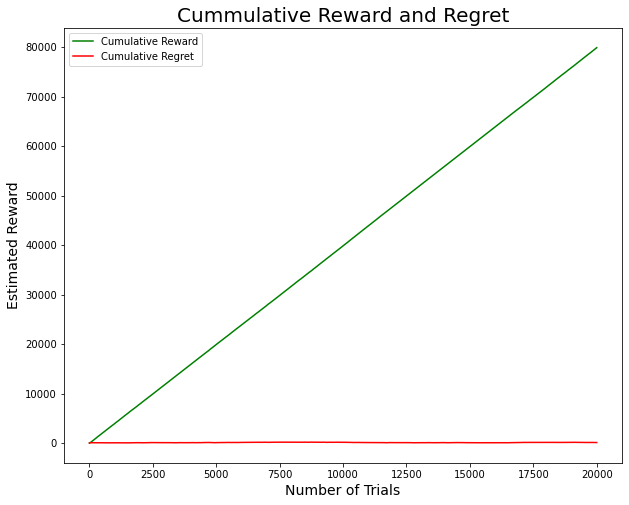

In [6]:
EpsilonGreedy(Bandit).plot1(eg_reward, eg_selected_bandit, BANDIT_REWARD)

In [7]:
df = EpsilonGreedy(Bandit).report(BANDIT_REWARD, eps, count_suboptimal)

Estimated average reward where epsilon for A Bandit with 1 Reward = 4.9975012493753125e-05 : 0,
 number of times pulled 0

Estimated average reward where epsilon for A Bandit with 2 Reward = 4.9975012493753125e-05 : 0,
 number of times pulled 0

Estimated average reward where epsilon for A Bandit with 3 Reward = 4.9975012493753125e-05 : 0,
 number of times pulled 0

Estimated average reward where epsilon for A Bandit with 4 Reward = 4.9975012493753125e-05 : 0,
 number of times pulled 0

Percent suboptimal where epsilon = 4.9975012493753125e-05 : 0.0019

Cummulative average: [1.46830275 1.68401657 1.05381122 ... 3.99504556 3.9949369  3.9949413 ]


In [8]:
class ThompsonSampling(Bandit):
    
    def __init__(self, true_mean):
        self.true_mean = true_mean
        self.m = 0
        self.lambda_ = 1
        self.tau = 1
        self.N = 0
        self.sum_x = 0
        
    def __repr__(self):
        return f"A Bandit with {self.true_mean} Win Rate"

    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean

    def sample(self):
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        self.m = (self.tau * x + self.lambda_ * self.m) / (self.tau + self.lambda_)
        self.lambda_ += self.tau
        self.N += 1
    
    def experiment(self, bandit_rewards, N=NUMBER_OF_TRIALS):
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        
        sample_points = [100, 1000, 2000, 5000, 10000, 19999]
        
        # empty array to later add the rewards for inference plots
        t_rewards = np.empty(N)
        t_selected_bandit = []
        
        for i in range(N):
            j = np.argmax([b.sample() for b in bandits]) #taking the highest mean position
            
            # make some plots
            if i in sample_points:
                self.plot2(bandits, i)
            
            # pull the chosen bandit and get the output
            x = bandits[j].pull()

            # increases N by 1, updates lambda and calculates the estimate of the m
            bandits[j].update(x)
            
            # add the reward to the data
            t_rewards[i] = x
            
            # Add the selected bandit to the list
            t_selected_bandit.append(j)
        
        all_bandits = pd.DataFrame({"Bandit" : t_selected_bandit, "Reward" : t_rewards, "Algorithm" : "Thompson Sampling"})
        all_bandits.to_csv("./csv/ThompsonSampling_All.csv")

        return t_rewards, t_selected_bandit
    
    def plot1(self, t_rewards, t_selected_bandit, bandit_rewards, N=NUMBER_OF_TRIALS):
        
        bandits = [ThompsonSampling(m) for m in bandit_rewards]
        
        actual_rewards = []
        for i in t_selected_bandit:
            actual_rewards.append(bandits[i].true_mean)
        
        true_best = max(bandit_rewards)
        best_reward = np.arange(N)
        
        regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(t_rewards)   # estimated reward
        #regret = np.cumsum(np.full_like(best_reward, true_best)) - np.cumsum(actual_rewards)   # actual reward
        
        plt.figure(figsize=(10, 8))
        plt.plot(np.cumsum(t_rewards), label = "Cumulative Reward", color = 'g')
        plt.plot(regret, label = "Cumulative Regret", color = 'r')
        plt.title("Cummulative Reward and Regret", fontsize=20)
        plt.xlabel("Number of Trials", fontsize=14)
        plt.ylabel("Estimated Reward", fontsize=14)
        plt.legend()
        plt.show()
    
    def plot2(self, bandits, trial):
    
        x = np.linspace(-3, 6, 200)
        for b in bandits:
            y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
            plt.plot(x, y, label = f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
            plt.title(f"Bandit distributions after {trial} trials")
        plt.legend()
        plt.show()
        
    def report(self, bandit_rewards, N=NUMBER_OF_TRIALS):
        
        bandits = [ThompsonSampling(m) for m in bandit_rewards]  
        
        cumulative_average = np.cumsum(t_rewards) / (np.arange(N) + 1)
        for b in bandits:
            print(f"Estimated average reward {b} {b.m},\n number of times pulled {b.N}\n")
        print(f'Cummulative average: {cumulative_average}')
        
        df = pd.DataFrame()
        df["Bandit"] = [b for b in bandits]
        df["Reward"] = [b.m for b in bandits]
        df["Algorithm"] = "ThompsonSampling"
        
        df.to_csv("./csv/ThompsonSampling_Last.csv")
        
        return df

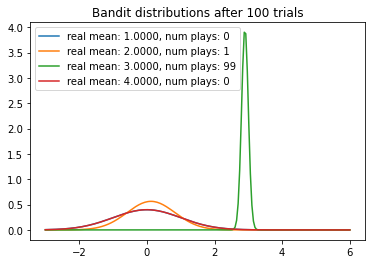

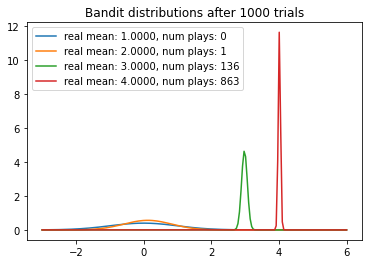

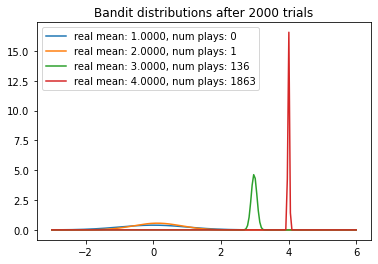

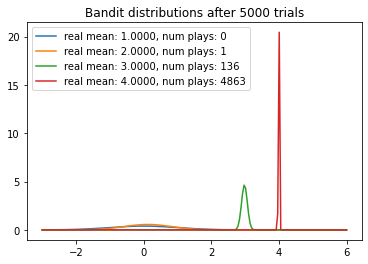

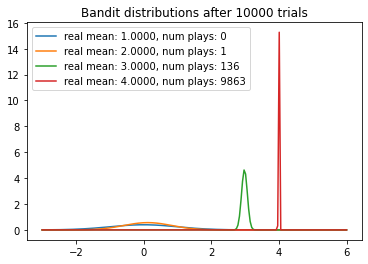

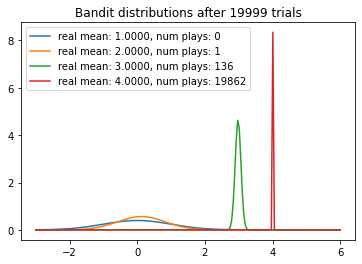

In [9]:
t_rewards, t_selected_bandit = ThompsonSampling(Bandit).experiment(BANDIT_REWARD, NUMBER_OF_TRIALS)

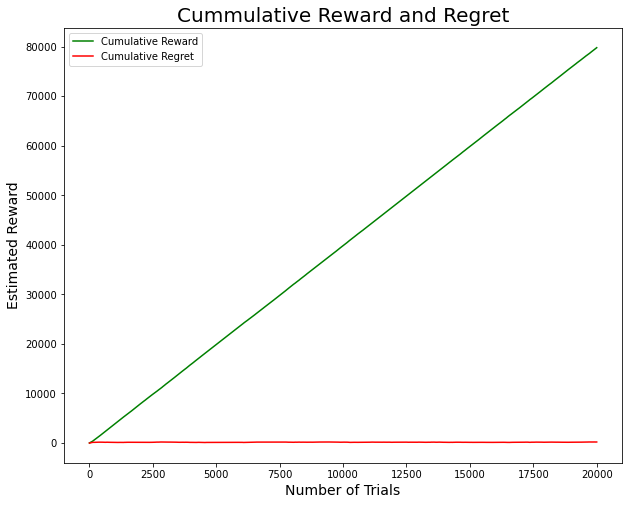

In [10]:
ThompsonSampling(Bandit).plot1(t_rewards, t_selected_bandit, BANDIT_REWARD)

In [11]:
df = ThompsonSampling(Bandit).report(BANDIT_REWARD)

Estimated average reward A Bandit with 1 Win Rate 0,
 number of times pulled 0

Estimated average reward A Bandit with 2 Win Rate 0,
 number of times pulled 0

Estimated average reward A Bandit with 3 Win Rate 0,
 number of times pulled 0

Estimated average reward A Bandit with 4 Win Rate 0,
 number of times pulled 0

Cummulative average: [4.63189894 4.13062123 3.63602151 ... 3.98953328 3.98945061 3.98950401]


In [12]:
def comparison(): # this may be stored in utils.py if you decide to build a package
    # think of a way to compare the performances of the two algorithms VISUALLY and 
    pass